# Определение стоимости автомобилей

Цель проекта - определение рыночной стоимости автомобиля по его описанию.
Для решения задачи предосмтавлен датасет с историческими данными: техническими характеристиками, комплектацией и ценой автомобилей.
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
import time
from sklearn.dummy import DummyRegressor
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('D:\\Documents\\ds\\auto\\autos.csv')
# df = pd.read_csv('/datasets/autos.csv')

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# Приводим названия столлбцов в змеиный регистр
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'numberof_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'numberof_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [4]:
# Просмотр категориальных данных
cate_date = ['vehicle_type', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'not_repaired']
for i in cate_date:
    print(i)
    print(df[i].value_counts(), '\n')

vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64 

gearbox
manual    268251
auto       66285
Name: gearbox, dtype: int64 

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64 

registration_month
0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: registration_month, dtype: int64 

fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        9

In [5]:
# Функция вывода гистограммы
def hist(i):
    plt.figure(figsize=(22, 7))
    sns.histplot(data=df[i], kde = True)
    plt.grid(linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.show

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


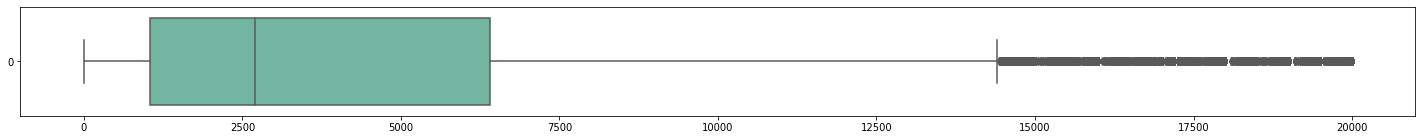

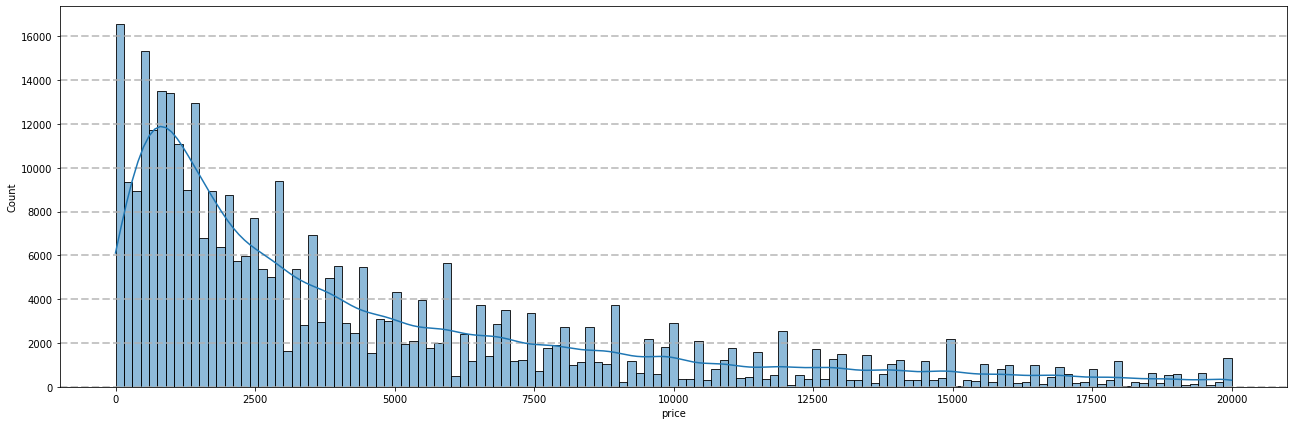

In [6]:
# Анализ расспределения целевого признака
print(df['price'].describe())

plt.figure(figsize=(25, 2))
sns.boxplot(data=df['price'], orient='h', palette='Set2')
plt.show

hist('price')

In [7]:
# Удаление нулевых значений целевого признака
print('Количество нулевых значений:', df[df['price']==0]['price'].count())
df = df[df['price']>0]
print('Нулевые значения после обработки:', df[df['price']==0]['price'].count())

Количество нулевых значений: 10772
Нулевые значения после обработки: 0


count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

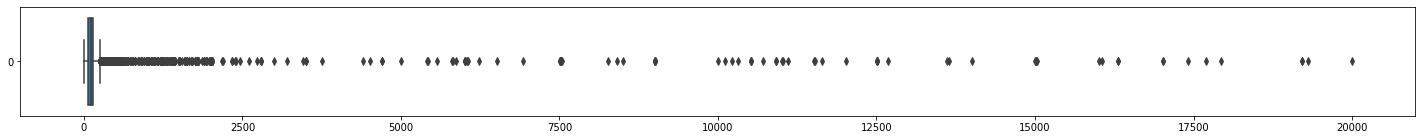

In [8]:
# Анализ расспределения столбца "power"
print(df['power'].describe())

plt.figure(figsize=(25, 2))
sns.boxplot(data=df['power'], orient='h')
plt.show

Количество  нулевых значений и значений ниже 20: 36760
Количество  нулевых значений и значений ниже 20 после обработки: 0


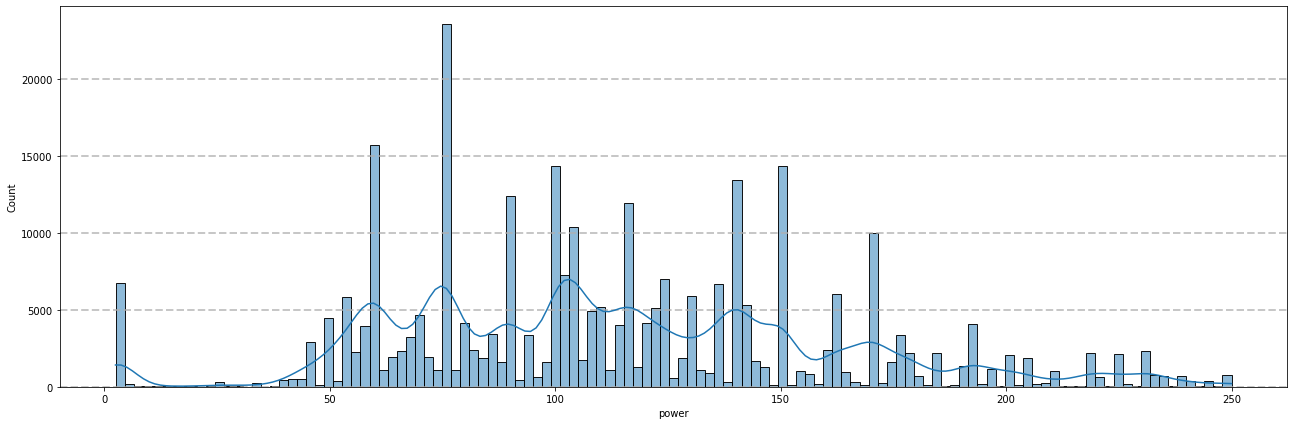

In [9]:
# В стобце 'power' удаляем нулевые значения, и исправляем выбросы
print('Количество  нулевых значений и значений ниже 20:', df[df['power']<20]['power'].count())
df = df[df['power']>=20]
print('Количество  нулевых значений и значений ниже 20 после обработки:', df[df['power']<0]['power'].count())
df['power'] = df.power.apply(lambda r: r/100 if r>250 else r)

hist('power')

count    306837.000000
mean     128496.775161
std       36654.192580
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


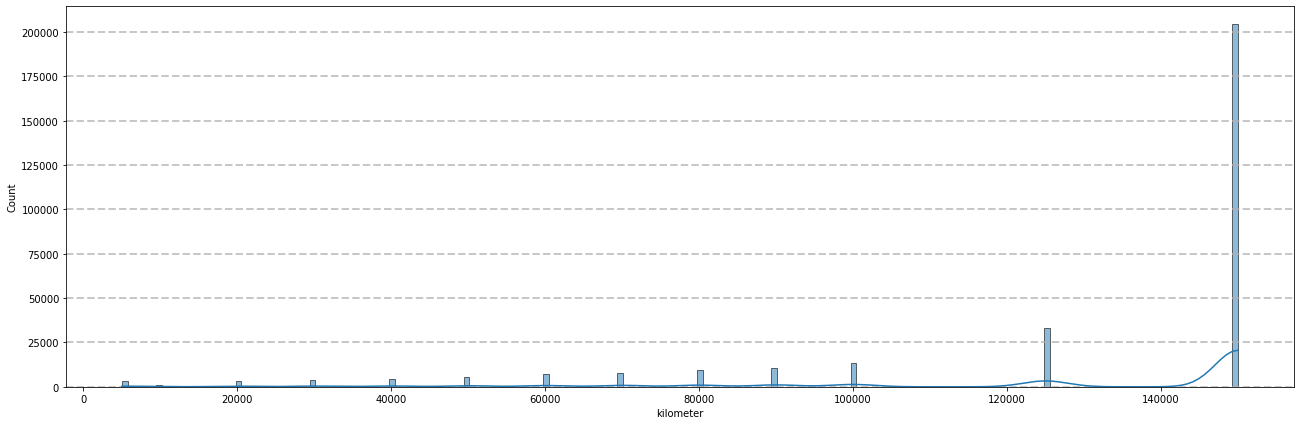

In [10]:
# Анализ расспределения столбца "kilometer"
print(df['kilometer'].describe())
hist('kilometer')

В столбце 'kilometer' аномальных значений и выбросов нет

In [11]:
# Анализ расспределения столбца "registration_year"
print(df['registration_year'].describe())

count    306837.000000
mean       2003.522857
std          33.223277
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


Количество  аномальных значений : 2163
Количество  аномальных значений  после обработки: 0


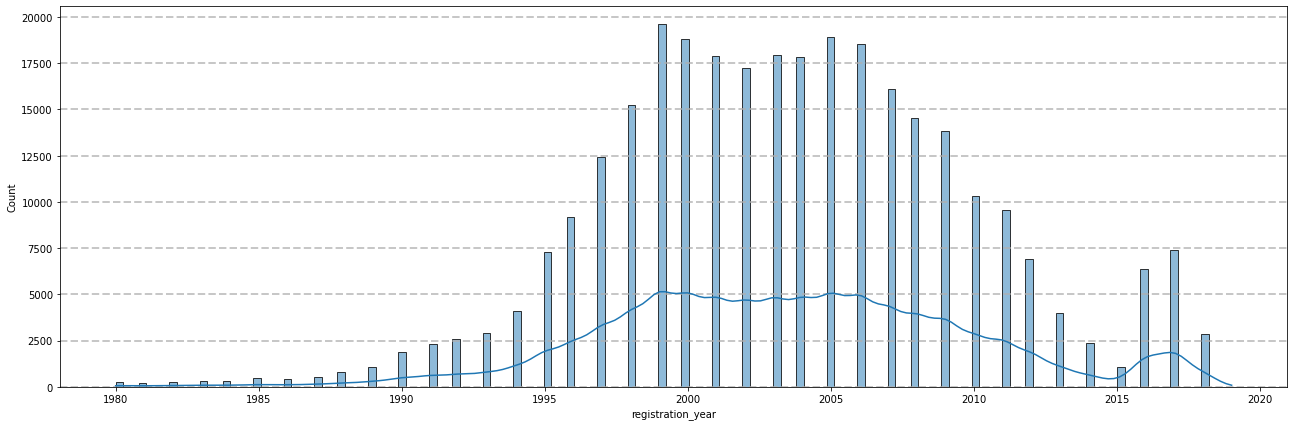

In [12]:
# Удаление выбросов столбца "registration_year"

print('Количество  аномальных значений :',
      df[(df['registration_year']<1980) | (df['registration_year']>2022)]['price'].count())

df = df[(df['registration_year']>=1980) & (df['registration_year']<=2022)]

print('Количество  аномальных значений  после обработки:',
      df[(df['registration_year']<1980) | (df['registration_year']>2022)]['price'].count())

hist('registration_year')

In [13]:
print(df['model'].describe())

df['model'].describe()

count     292833
unique       248
top         golf
freq       25992
Name: model, dtype: object


count     292833
unique       248
top         golf
freq       25992
Name: model, dtype: object

Аномальных значений, выбросов в признаке 'model' нет

In [14]:
# Заполнение пропусков столбца "not_repaired"
df['not_repaired'].fillna('unknow', inplace=True)

# Удаление строк с пропусками
df.dropna(subset=['vehicle_type', 'gearbox', 'fuel_type', 'model'], inplace=True)

In [15]:
# Удаление  столбцов не влиящих на целевой признак
df.drop(columns=['registration_month', 'date_crawled', 'date_created', 'postal_code', 'last_seen', 'numberof_pictures', 'numberof_pictures'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262146 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              262146 non-null  int64  
 1   vehicle_type       262146 non-null  object 
 2   registration_year  262146 non-null  int64  
 3   gearbox            262146 non-null  object 
 4   power              262146 non-null  float64
 5   model              262146 non-null  object 
 6   kilometer          262146 non-null  int64  
 7   fuel_type          262146 non-null  object 
 8   brand              262146 non-null  object 
 9   not_repaired       262146 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 22.0+ MB


### Вывод
В представленном датасете 354369 строк и 16 столбцов.
В датасете присутствовали пропуски значений, аномальные данные, выбросы.

Было выполнено следующее:  
Удалены признаки не влиящие на целевой показатель 'date_crawled', 'date_created', 'postal_code', 'last_seen'.  
В стобцах 'price', 'power', 'registration_year' удалены выбросы.  
В столбце 'power' преобразованы аномальные данные.    
Пропуски в столбце "not_repaired" заполнены значением 'unknow', остальные пропуски удалены.  
Так как будут использоваться модели обучения которые про разному обрабатывают категориальные признаки, преобразование данных столбцов будет проведено перед использованием моделей.  

## Обучение моделей

In [16]:
# Масштабирование
scaler = preprocessing.MinMaxScaler()
for i in ['registration_year', 'power', 'kilometer']:
    df[i] = scaler.fit_transform(df.loc[:, [i]])

###  Модель CatBoostRegressor

#### Подготовка обучающей и валидационной выборок для модели CatBoostRegressor

In [17]:
# Выделение в выборках признаков и целевого признака
target = df['price']
features = df.drop('price', axis=1)

# Разбивка на обучающую выборку и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.25, random_state=12345)

for i  in [features_train, features_valid, target_train, target_valid]:
    print(i.shape)
features.info()

(196609, 9)
(65537, 9)
(196609,)
(65537,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 262146 entries, 2 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       262146 non-null  object 
 1   registration_year  262146 non-null  float64
 2   gearbox            262146 non-null  object 
 3   power              262146 non-null  float64
 4   model              262146 non-null  object 
 5   kilometer          262146 non-null  float64
 6   fuel_type          262146 non-null  object 
 7   brand              262146 non-null  object 
 8   not_repaired       262146 non-null  object 
dtypes: float64(3), object(6)
memory usage: 20.0+ MB


#### Обучение и предсказние модели CatBoostRegressor

In [18]:
%%time
# Обучение модели CatBoostRegressor
train_pool = Pool(features_train, target_train, cat_features=[0,2,4,6,7,8])
test_pool = Pool(features_valid, cat_features=[0,2,4,6,7,8]) 

model_cat = CatBoostRegressor(logging_level='Silent')
model_cat.fit(train_pool)

CPU times: total: 9min 27s
Wall time: 1min 18s


In [19]:
%%time
# Предсказание модели CatBoostRegressor
pred_cat = model_cat.predict(test_pool)
rmse_cat = np.sqrt(mean_squared_error(target_valid, pred_cat))
print('RMSE = ','%.0f'% rmse_cat)
CatBoost = ['CatBoostRegressor', round(rmse_cat), '9min 34s', '1min 20s', '734 ms', '53 ms']

RMSE =  1523
CPU times: total: 734 ms
Wall time: 52 ms


### Модель LightGBM

#### Подготовка обучающей и валидационной выборок для модели LightGBM

In [20]:
# Преобразование категориальных признаков методом "кодирования меток"
cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
for item in cols:
    df[item] = df[item].astype('category').cat.codes + 1

target = df['price']
features = df.drop('price', axis=1)

# Разбивка на обучающую выборку и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.25, random_state=12345)

features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
120144,6,0.447368,2,0.232292,103,1.0,7,11,2
318042,5,0.500000,2,0.595943,12,1.0,7,3,1
266349,8,0.763158,1,0.676755,60,1.0,3,21,1
134846,6,0.710526,2,0.430280,81,1.0,3,22,1
31376,2,0.473684,2,0.769688,12,1.0,7,3,1


####  Обучение и предсказние модели LightGBM

In [21]:
%%time

# Преобразование в формат данных набора данных
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)
 
# Параметры
params = {
    'task': 'train',
         'boosting_type': 'gbdt', 
         'target': 'regression',
         'metric': 'l2_root'
}

# Вызов модели LightGBM и использование данных для обучения
my_model = lgb.train(params, lgb_train, num_boost_round=20,
                     valid_sets=lgb_eval, verbose_eval=0, categorical_feature=[0,2,4,6,7,8])


[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 196609, number of used features: 9
[LightGBM] [Warning] Unknown parameter: target
[LightGBM] [Info] Start training from score 5049.528587
CPU times: total: 2.19 s
Wall time: 173 ms


In [22]:
%%time

# Предсказание на основе данных тестового набора
predictions = my_model.predict(features_valid, num_iteration=my_model.best_iteration)

# Оценка результатов прогноза модели
rmse_lgb = np.sqrt(mean_squared_error(predictions, target_valid))
print('RMSE: ', '%.0f'% rmse_lgb)
LightGBM = ['LightGBM', round(rmse_lgb), '2.2 s', '185 ms', '219 ms', '18 ms']

RMSE:  1886
CPU times: total: 250 ms
Wall time: 18 ms


###  Модель LinearRegression

#### Подготовка обучающей и валидационной выборок для модели LinearRegression

In [23]:
df_lg = df.copy()

# Преобразование категориального признака 'model' в числовой
# Применение One Hot Encoding для данного признака приведет к сильному увелечиние времени обучения модели
df_lg['model_price'] = df_lg.groupby(['model', 'registration_year']).price.transform('mean')

# Применение One Hot Encoding для остальных категориальных признаков
df_lg = pd.get_dummies(df_lg, columns=['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'not_repaired'], drop_first=True)

target = df_lg['price']
features = df_lg.drop(['price', 'model'], axis=1)

# Разбивка на обучающую выборку и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.25, random_state=12345)

for i  in [features_train, features_valid, target_train, target_valid]:
    print(i.shape)
features.head()

(196609, 58)
(65537, 58)
(196609,)
(65537,)


,registration_year,power,kilometer,model_price,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,vehicle_type_6,vehicle_type_7,...,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,not_repaired_2,not_repaired_3
2,0.631579,0.648471,0.827586,5326.470588,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.552632,0.292901,1.000000,2657.198039,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0.736842,0.268657,0.586207,5055.741007,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,0.394737,0.401996,1.000000,1761.472477,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0.631579,0.430280,1.000000,2386.563776,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Обучение и предсказние модели LinearRegression

In [24]:
%%time

# Обучение модели LinearRegression
parametrs = [{'fit_intercept':[True, False], 'copy_X': [True, False], 'positive': [True, False]}]
model_lrg = GridSearchCV(LinearRegression(), parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
model_lrg.fit(features_train, target_train)

CPU times: total: 3.58 s
Wall time: 18.1 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'positive': [True, False]}],
             scoring='neg_root_mean_squared_error')

In [25]:
%%time

# Предсказание модели LinearRegression
pred_lrg = model_lrg.predict(features_valid)
rmse_lrg = np.sqrt(mean_squared_error(target_valid, pred_lrg))
print('RMSE = ','%.0f'% rmse_lrg)
LinearReg = ['LinearRegression', round(rmse_lrg), '3.48 s', '16 s', '15.6 ms', '13 ms']

RMSE =  1930
CPU times: total: 0 ns
Wall time: 13 ms


###  Проверка моделей на адекватность

In [26]:
for i in ['mean', 'median']:
    model_mean = DummyRegressor(strategy=i)
    model_mean.fit(features_train, target_train)
    predict = model_mean.predict(features_valid)
    score = np.sqrt(mean_squared_error(target_valid, predict))
    print('rmse strategy', i,'%.0f'% score)

rmse strategy mean 4649
rmse strategy median 4919


## Анализ моделей

In [27]:
# Вывод таблицы с результами работы моделей
tab = pd.DataFrame([CatBoost, LightGBM, LinearReg],
                    columns=['Model', 'RMSE', 'learn_CPU_times', 'learn_Wall_time', 'pred_CPU_times', 'pred_Wall_time'])
display(tab)

,Model,RMSE,learn_CPU_times,learn_Wall_time,pred_CPU_times,pred_Wall_time
0,CatBoostRegressor,1523,9min 34s,1min 20s,734 ms,53 ms
1,LightGBM,1886,2.2 s,185 ms,219 ms,18 ms
2,LinearRegression,1930,3.48 s,16 s,15.6 ms,13 ms


### Вывод
Самая точная модель машинного обучения на данном датасете - CatBoostRegressor. RMSE модели равен 1523. У моделей LightGBM и LinearRegression RMSE соответственно равен 1881 и 1930.  
При самой высокой точности модель CatBoostRegressor самая медленная при обучении и при предсказании. Самая быстро обучающаяся  – LinearRegression при самом низком показании точности прогноза.  
Модели были проверены на адекватность. Все модели имеют предсказательную силу.  
При выборе модели обучения для определения стоимости автомобиля следует определить, что важнее точность предсказания или затрачиваемое время (вычислительные ресурсы) при более низком точности предсказания.
Если важна точность следует выбрать модель CatBoostRegressor, если важны меньшие вычислительные ресурсы следует выбрать модель LightGBM или LinearRegression.